# Breast Cancer Classification with KNN (Wisconsin Diagnostic)

- Goal: Predict Malignant (1) vs Benign (0)
- Method: KNN inside a Pipeline (StandardScaler + KNN), tuned K and metric (Manhattan, K=3)
- Metrics: Accuracy, Precision, Recall, F1, Confusion Matrix
- Focus: High Recall for Malignant to reduce false negatives


In [5]:
import pandas as pd

# Load the dataset you uploaded
df = pd.read_csv("data.csv")

# Show the first 5 rows
df.head()

# Remove the useless ID column
if "id" in df.columns:
    df = df.drop(columns=["id"])

# Check for missing (blank) values in each column
df.isnull().sum()


# 1) Map diagnosis: M=1 (malignant), B=0 (benign)
df['diagnosis'] = df['diagnosis'].map({'M':1, 'B':0})

# 2) Drop any weird unnamed column if present (sometimes appears on Kaggle CSVs)
to_drop = [c for c in df.columns if c.lower().startswith('unnamed')]
if to_drop:
    df = df.drop(columns=to_drop)

df.head()

from sklearn.model_selection import train_test_split

X = df.drop(columns=['diagnosis'])   # all inputs
y = df['diagnosis']                  # the label we predict

# Stratify so class balance is preserved
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_train.shape, X_test.shape

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

knn_pipe = Pipeline(steps=[
    ('scale', StandardScaler()),        # z-score normalization
    ('knn', KNeighborsClassifier(n_neighbors=7, weights='distance', metric='minkowski'))
])

knn_pipe.fit(X_train, y_train)



Pipeline(steps=[('scale', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=7, weights='distance'))])

Accuracy: 0.9649122807017544

Classification report:
               precision    recall  f1-score   support

      Benign       0.95      1.00      0.97       107
   Malignant       1.00      0.91      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.97      0.96      0.96       171



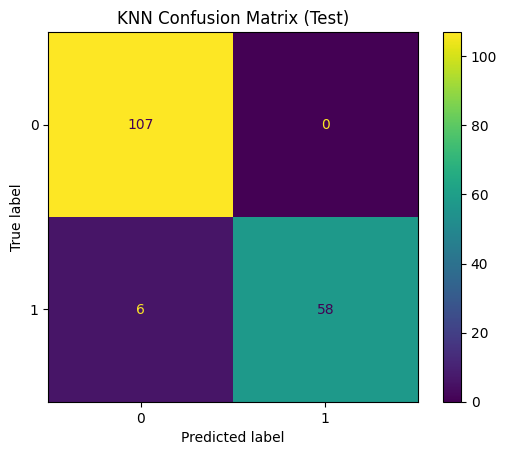

In [6]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = knn_pipe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=['Benign','Malignant']))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("KNN Confusion Matrix (Test)")
plt.show()


In [7]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, recall_score

candidates = [3,5,7,9,11,13,15]
rows = []

for k in candidates:
    pipe = Pipeline([
        ('scale', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=k, weights='distance'))  # distance weights help
    ])
    pipe.fit(X_train, y_train)
    y_hat = pipe.predict(X_test)

    # overall and malignant-specific metrics
    f1_macro = f1_score(y_test, y_hat, average='macro')
    rec_malignant = recall_score(y_test, y_hat)  # positive class is 1 (malignant)
    rows.append((k, f1_macro, rec_malignant))

print("K  | F1(macro) | Recall(Malignant)")
for k, f1m, r1 in rows:
    print(f"{k:2} |   {f1m:0.3f}   |     {r1:0.3f}")

best_k = max(rows, key=lambda t: (t[2], t[1]))[0]  # prioritize malignant recall, then F1
print("\nBest K (prioritizing malignant recall, then F1):", best_k)


K  | F1(macro) | Recall(Malignant)
 3 |   0.955   |     0.891
 5 |   0.962   |     0.906
 7 |   0.962   |     0.906
 9 |   0.956   |     0.906
11 |   0.956   |     0.906
13 |   0.942   |     0.875
15 |   0.942   |     0.875

Best K (prioritizing malignant recall, then F1): 5


Accuracy: 0.9649122807017544

Classification report:
               precision    recall  f1-score   support

      Benign       0.95      1.00      0.97       107
   Malignant       1.00      0.91      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.95      0.96       171
weighted avg       0.97      0.96      0.96       171



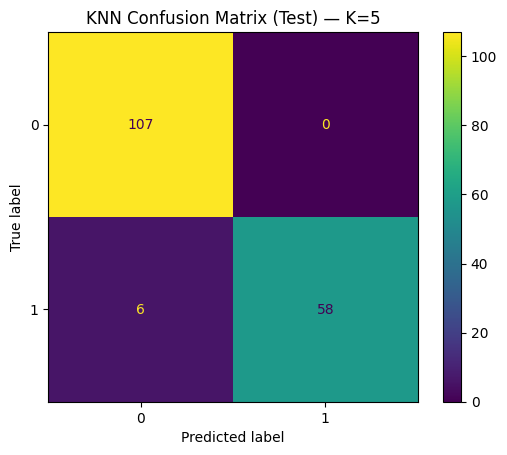

In [8]:
best_k = 5  # keep from above, or set manually, e.g., best_k = 9

knn_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=best_k, weights='distance'))
])
knn_pipe.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = knn_pipe.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n",
      classification_report(y_test, y_pred, target_names=['Benign','Malignant']))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f"KNN Confusion Matrix (Test) — K={best_k}")
plt.show()


In [9]:
from sklearn.metrics import f1_score, recall_score

for metric in ['euclidean','manhattan']:
    for k in [3,5,7,9,11]:
        pipe = Pipeline([
            ('scale', StandardScaler()),
            ('knn', KNeighborsClassifier(n_neighbors=k, weights='distance', metric=metric))
        ])
        pipe.fit(X_train, y_train)
        y_hat = pipe.predict(X_test)
        print(f"metric={metric:9s}  K={k:2}  F1(macro)={f1_score(y_test, y_hat, average='macro'):.3f}  "
              f"Recall(Malignant)={recall_score(y_test, y_hat):.3f}")


metric=euclidean  K= 3  F1(macro)=0.955  Recall(Malignant)=0.891
metric=euclidean  K= 5  F1(macro)=0.962  Recall(Malignant)=0.906
metric=euclidean  K= 7  F1(macro)=0.962  Recall(Malignant)=0.906
metric=euclidean  K= 9  F1(macro)=0.956  Recall(Malignant)=0.906
metric=euclidean  K=11  F1(macro)=0.956  Recall(Malignant)=0.906
metric=manhattan  K= 3  F1(macro)=0.968  Recall(Malignant)=0.922
metric=manhattan  K= 5  F1(macro)=0.968  Recall(Malignant)=0.922
metric=manhattan  K= 7  F1(macro)=0.968  Recall(Malignant)=0.922
metric=manhattan  K= 9  F1(macro)=0.962  Recall(Malignant)=0.906
metric=manhattan  K=11  F1(macro)=0.962  Recall(Malignant)=0.906


✅ Final Model:
K = 3, Metric = manhattan
Accuracy: 0.9707602339181286

Classification Report:
               precision    recall  f1-score   support

      Benign       0.96      1.00      0.98       107
   Malignant       1.00      0.92      0.96        64

    accuracy                           0.97       171
   macro avg       0.98      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



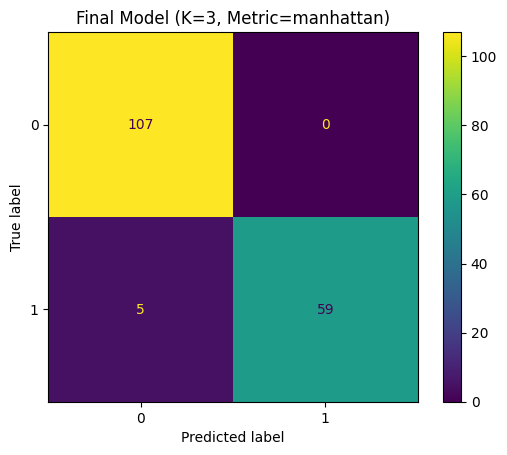

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Final chosen model
best_k = 3
best_metric = 'manhattan'

knn_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('knn', KNeighborsClassifier(
        n_neighbors=best_k,
        metric=best_metric,
        weights='distance'
    ))
])

# Train final model
knn_pipe.fit(X_train, y_train)

# Evaluate again
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = knn_pipe.predict(X_test)
print("✅ Final Model:")
print(f"K = {best_k}, Metric = {best_metric}")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n",
      classification_report(y_test, y_pred, target_names=['Benign','Malignant']))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f"Final Model (K={best_k}, Metric={best_metric})")
plt.show()
